Convert JSON to CSV

In [1]:
# Since google restaurant dataset is in json format, use pandas to convert it into a CSV file
# DO NOT RERUN
import pandas as pd 
df = pd.read_json(r'E:\AIEBA Datasets\Proj1 Datasets\GoogleRestaurantReview.json', lines=True)
df.to_csv(r'E:\AIEBA Datasets\Proj1 Datasets\GoogleRestaurantReview.csv', index = None)

FileNotFoundError: File E:\AIEBA Datasets\Proj1 Datasets\GoogleRestaurantReview.json does not exist

## Load in Datasets

In [1]:
# Load in all three datasets
# .csv files use the utf-8 encodings
import pandas as pd

amzn = pd.read_csv(r'E:\AIEBA Datasets\Proj1 Datasets\AmazonReviews.csv',encoding='utf-8',engine='python')
googl = pd.read_csv(r'E:\AIEBA Datasets\Proj1 Datasets\GoogleRestaurantReview.csv',encoding='utf-8',engine='python')
dis = pd.read_csv(r'E:\AIEBA Datasets\Proj1 Datasets\DisneylandReviews.csv',encoding='utf-8',engine='python')

# amzn = pd.read_csv(r'C:\AIEBA Datasets\Proj1 Datasets\AmazonReviews.csv',encoding='utf-8',engine='python')
# googl = pd.read_csv(r'C:\AIEBA Datasets\Proj1 Datasets\GoogleRestaurantReview.csv',encoding='utf-8',engine='python')
# dis = pd.read_csv(r'C:\AIEBA Datasets\Proj1 Datasets\DisneylandReviews.csv',encoding='utf-8',engine='python')

In [ ]:
amzn.head()

In [ ]:
googl.head()

In [ ]:
dis.head()

In [2]:
# Drop columns that are not needed and standardize column names
amzn = amzn.filter(items=['reviews.rating', 'reviews.text'])
amzn = amzn.rename(columns={"reviews.rating":"reviews_rating", "reviews.text":"reviews_text"})

googl = googl.filter(items=['rating', 'review_text'])
googl = googl.rename(columns={"rating":"reviews_rating", "review_text":"reviews_text"})

dis = dis.filter(items=['Rating','Review_Text'])
dis = dis.rename(columns={"Rating":"reviews_rating", "Review_Text":"reviews_text"})

amzn.head()

,reviews_rating,reviews_text
0,5.0,This $product so far has not%&^# disappointed....
1,5.0,great for beginner or experienced person. Boug...
2,5.0,Inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...
4,5.0,I bought this for my grand daughter when she c...


In [3]:
# Concatenate all 3 datasets by column
combined = pd.concat([amzn, googl, dis], ignore_index=True)
combined

,reviews_rating,reviews_text
0,5.0,This $product so far has not%&^# disappointed....
1,5.0,great for beginner or experienced person. Boug...
2,5.0,Inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...
4,5.0,I bought this for my grand daughter when she c...
...,...,...
1125886,5.0,i went to disneyland paris in july 03 and thou...
1125887,5.0,2 adults and 1 child of 11 visited Disneyland ...
1125888,5.0,My eleven year old daughter and myself went to...
1125889,4.0,"This hotel, part of the Disneyland Paris compl..."


## Data Cleansing and preprocessing

In [4]:
# remove rows with missing values
print(combined.isnull().sum())
combined = combined.dropna()


reviews_rating    55
reviews_text      16
dtype: int64


In [ ]:
#missing values removed 
print(combined.isnull().sum())

In [ ]:
combined["reviews_rating"].value_counts().plot.bar()
combined["reviews_rating"].value_counts(ascending=True)

,reviews_rating,reviews_text
18203,5.0,Super convenient. Battery life for weeks. Perf...
14901,5.0,My children love these kindles! They are so mu...
344876,5.0,"I have to say, I had a few choices to choose f..."
540077,5.0,Phenomenal BBQ combined with fast service and ...
1024969,5.0,The beef noodle soup is the star. You can't ge...
...,...,...
552208,1.0,Donâ€™t waste time or money!!!!!!! I live 3 mi...
1069965,1.0,(Translated by Google) We went here to eat the...
484556,1.0,We were anticipating a delightful experience a...
401200,1.0,128th Denny's is officially ghetto\nHave been ...


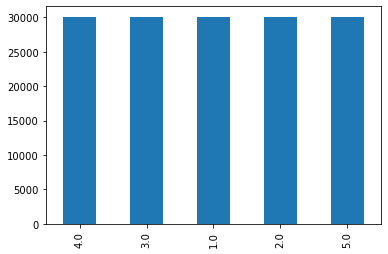

In [5]:
# perform undersampling to get balanced dataset

least_class_amount, class_1, class_3, class_4, class_5 = combined.reviews_rating.value_counts(ascending=True)

# create separate dataframes for each rating
c5 = combined[combined["reviews_rating"] == 5.0]
c4 = combined[combined["reviews_rating"] == 4.0]
c3 = combined[combined["reviews_rating"] == 3.0]
c2 = combined[combined["reviews_rating"] == 2.0]
c1 = combined[combined["reviews_rating"] == 1.0]

# randomly remove data to in each dataframe to match the number of rows in c2 which has the least amount of data
df_5 = c5.sample(least_class_amount, random_state=50)
df_4 = c4.sample(least_class_amount, random_state=50)
df_3 = c3.sample(least_class_amount, random_state=50)
df_1 = c1.sample(least_class_amount, random_state=50)

# concatenate all 5 dataframes into 1
undersampled = pd.concat([df_5, df_4, df_3, c2, df_1], axis=0)
combined = undersampled
combined.reviews_rating.value_counts().plot.bar()
combined.reviews_rating.value_counts()
combined

In [6]:
# remove non-ascii characters
combined["reviews_text"] = combined["reviews_text"].str.encode('ascii', 'ignore').str.decode('ascii')

In [7]:
# using regular expressions to remove unwanted characters and punctuations
import re

def cleanup(sentence):
  sentence = str(sentence).lower()
  sentence = cleanup_re.sub('',sentence).strip() 
  sentence = re.sub('[\d]','',sentence) # remove all digits and numbers
  return sentence

def to_int(rating):
    rating = int(rating) - 1
    if rating >= 3:
      rating = 2 # positive
    elif rating <= 1:
      rating = 0 # negative
    else:
      rating = 1
    return rating # neutral
  
cleanup_re = re.compile('[^\w\s]') # match whitespaces words only
combined["reviews_text"] = combined["reviews_text"].apply(cleanup)
combined["reviews_rating"] = combined["reviews_rating"].apply(to_int)
combined

,reviews_rating,reviews_text
18203,2,super convenient battery life for weeks perfec...
14901,2,my children love these kindles they are so muc...
344876,2,i have to say i had a few choices to choose fr...
540077,2,phenomenal bbq combined with fast service and ...
1024969,2,the beef noodle soup is the star you cant get ...
...,...,...
552208,0,dont waste time or money i live miles away fr...
1069965,0,translated by google we went here to eat the n...
484556,0,we were anticipating a delightful experience a...
401200,0,th dennys is officially ghetto\nhave been here...


In [8]:
# remove stopwords 
import nltk
from nltk.corpus import stopwords

def remove_stopwords(sentence):
  sentence = sentence.split()
  sentence = [word for word in sentence if word not in stoplist]
  sentence = ' '.join(sentence)
  return sentence
    

def custom_stoplist():
  stop_words = set(stopwords.words('english'))
  wanted_stopwords = {'not', 'nor', 'no', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'very'} # stopwords that can change a sentence's meaning
  stoplist = stop_words - wanted_stopwords
  return stoplist

stoplist = custom_stoplist()
combined["reviews_text"] = combined["reviews_text"].apply(remove_stopwords)
combined

,reviews_rating,reviews_text
18203,2,super convenient battery life weeks perfect mo...
14901,2,children love kindles much better st ones had ...
344876,2,have say had choices choose dinner tonight hap...
540077,2,phenomenal bbq combined fast service lots room...
1024969,2,beef noodle soup star cant get dish anywhere e...
...,...,...
552208,0,dont waste time money live miles away restaura...
1069965,0,translated google went eat nola gumbo ordered ...
484556,0,anticipating delightful experience restaurant ...
401200,0,th dennys officially ghetto have min no food s...


In [ ]:
combined["reviews_rating"].value_counts().plot.bar()
combined["reviews_rating"].value_counts(ascending=True)

In [9]:
# perform 80-20 split on data
from sklearn.model_selection import train_test_split

sentences = combined["reviews_text"].tolist()
labels = combined["reviews_rating"].tolist()
print(len(sentences))
training_sentences, test_sentences, training_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, train_size=0.8, random_state=35) 
# random_state controls how data is being shuffled
# ensures that data is being shuffled the same way every time the cell is being ran

150460


In [10]:
type(tra)

list

In [ ]:
test_labels

## Constructing the Embedding Layer

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

vocab_size = 40000 # number of words that will be fed into model #91334
max_length = 100 #
trunc_type='post' # 
padding_type='post' #
oov_tok = "<OOV>" # placeholder if model encounters words it has never seen before in the test set

# Tokenization - breaking down sentences into its individual words and assigning a number to it
tokenizer = Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index # Model's 'vocabulary' learnt from training data (corpus)
vocab_length = len(word_index) + 1
print(vocab_length)

# Sequencing - converting each sentence into its numerical equivalent
# Padding and truncating used to make all sentences same length 
training_sequences = tokenizer.texts_to_sequences(training_sentences) # convert each word to its respective index of the corpus
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type,
                               truncating=trunc_type) # add padding to sequence to ensure 100 index length

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type,
                               truncating=trunc_type)

91284


In [12]:
# since neural nets do not perform well on sparse data, sequences need to be converted to vectors instead of binary values 
# Use GloVe word embeddings 
from numpy import asarray
from numpy import zeros

embeddings_dict = {}
embeddings_file = open('E:\GloVe Word Embeddings\glove.6B.100d.txt', encoding='utf8')

for line in embeddings_file:
  records = line.split()
  word = records[0]
  vector_dimensions = np.asarray(records[1:], dtype='float32')
  embeddings_dict[word] = vector_dimensions

embeddings_file.close()

In [13]:
# create embedding matrix by assigning the word vector in GloVe file to the corresponding word from the corpus
embedding_matrix = np.zeros((vocab_length, 100))
for word, index in word_index.items():
  embedding_vector = embeddings_dict.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector
print(embedding_matrix.shape)

(91284, 100)


In [14]:
##  to categorical
training_labels = tf.keras.utils.to_categorical(training_labels, num_classes=None)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=None)

In [18]:
type(test_labels)

numpy.ndarray

## Model Building (Simple NN)

In [ ]:
# # perform one-hot encoding on sequences - convert sequences into binary values
# training_padded = np.array(training_padded)
# training_labels = tf.keras.utils.to_categorical(training_labels)
# test_padded = np.array(test_padded)
# test_labels = tf.keras.utils.to_categorical(test_labels)

In [ ]:
# print(training_padded)
# print(training_labels)

In [ ]:
# num_of_ratings = 6 # number of possible ratings given by users: 1 to 5
# embedding_dim = 32
# # Creating a model with 3 fully connected layers:
# # 1 embedding layer to find correlation between words, 1 pooling layer, 1 layer with relu function 
# model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_length, embedding_dim, input_length=maxlen),
#     tf.keras.layers.GlobalAveragePooling1D(),
#     tf.keras.layers.Dense(24, activation='relu'), 
#     tf.keras.layers.Dense(num_of_ratings, activation='softmax')
# ]) 
# model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
# model.summary()

In [ ]:
# Training model

#epochs_2 = 10
#prediction_2 = model.fit(training_padded, training_labels, epochs=epochs_2, validation_data=(test_padded, test_labels), verbose=2)

# epochs_2 = 70
# history = model.fit(training_padded, training_labels, epochs=epochs_2, validation_data=(test_padded, test_labels), verbose=2)


In [ ]:
# sentence = ["food took too long to come but overall experience was ok"]
# sequences = tokenizer.texts_to_sequences(sentence)
# padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# output= model.predict(padded)

# print(output)
# print("Review:", sentence)
# print("Rating:", np.argmax(output, axis=None, out=None))

## Model Building & Training (LSTM)

In [ ]:
test_labels

In [ ]:
# LSTM model architecture
from keras.models import Sequential 
from keras.layers.core import Activation, Dense
from keras.layers import Embedding, LSTM

embedding_layer = tf.keras.layers.Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=max_length, trainable=False)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model = Sequential()
model.add(embedding_layer)
model.add(tf.keras.layers.LSTM(128, dropout=0.3))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
tf.debugging.set_log_device_placement(True)
history = model.fit(training_padded, training_labels, batch_size=64, callbacks=[callback], epochs=30, verbose=1, validation_split=0.2)

In [ ]:
score = model.evaluate(test_padded, test_labels, verbose=2)

In [ ]:
# plot model performance charts 

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# save model
model.save(f"E:\Saved_NLP_models\c1_lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

## Keras tuner 

In [ ]:
# Keras tuner
from keras.models import Sequential 
from keras.layers.core import Activation, Dense
from keras.layers import Embedding, LSTM
import keras_tuner as kt

def model_building (hp):

    embedding_dims = hp.Int('output_dim', min_value=8, max_value=128, step=8)
    dense_units = hp.Int('units', min_value=8, max_value=128, step=8)
    dropout = hp.Int('dropout', min_value=8, max_value=128, step=8)
    lstm_units = hp.Int('units', min_value=8, max_value=128, step=8)

    embedding_layer = tf.keras.layers.Embedding(vocab_length, embedding_dims=embedding_dims, weights=[embedding_matrix], input_length=max_length, trainable=False)
    model = Sequential()
    model.add(embedding_layer)
    model.add(tf.keras.layers.LSTM(units=lstm_units, dropout=dropout))
    model.add(tf.keras.layers.Dense(units=dense_units, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(model_building,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# Hyperparameter optimisation 
tuner.search(training_padded, training_labels, epochs=50, validation_data=(test_padded, test_labels), callbacks=[callback])

In [ ]:
# Retreiving best hyper params
best_hps_rs=tuner.get_best_hyperparameters()[0]
# Creating model with hyper params 
hypermodel_rs = tuner.hypermodel.build(best_hps_rs)

In [ ]:
history = hypermodel_rs.fit(training_padded, training_labels, epochs=10, validation_data=(test_padded, test_labels), callbacks=[callback])

In [ ]:
# Get the best epoch (OPTIONAL)
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
# Rerun with the best epoch (OPTIONAL)
history = hypermodel_rs.fit(training_padded, training_labels, epochs=best_epoch, validation_data=(test_padded, test_labels), callbacks=[callback])

## Testing Model on Unseen Data 

In [ ]:
# testing model on unseen data 

unseen = pd.read_csv(r'E:\AIEBA Datasets\Proj1 Datasets\unseen_data.csv',encoding='utf-8',engine='python')
unseen["reviews_text"] = unseen["reviews_text"].apply(cleanup)
unseen_reviews = unseen["reviews_text"].tolist()
unseen_tokenized = tokenizer.texts_to_sequences(unseen_reviews)
unseen_padded = pad_sequences(unseen_tokenized, padding='post',maxlen=max_length)


In [ ]:
predicted_ratings = []
sentiments = model.predict(unseen_padded)
for sentiment in sentiments:
  predicted_ratings.append(np.argmax(sentiment))

unseen["predicted_ratings"] = predicted_ratings
unseen

In [ ]:
sentence = ["service was good and food was insanely good"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
output= model.predict(padded)

print(output)
print("Review:", sentence)
print("Rating:", np.argmax(output, axis=None, out=None))